### Adhlere Coffy

### PUI HW 10 - Clustering Businesses in NYC

### December 14, 2015

In [30]:
import pandas as pd
import json
import numpy as np 
import pylab as pl
from pandas.tools.plotting import scatter_matrix

import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans
import scipy

import urllib2
import zipfile 
from StringIO import StringIO
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sys
import os
s = json.load( open(os.getenv('PUI2015') + '/fbb_matplotlibrc.json') )
pl.rcParams.update(s)


%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

In [3]:
# Load json shape file of NYC

shapeURL = urllib2.urlopen("https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson")
nycSHP = json.load(shapeURL)

In [4]:
# pull the zips for nyc from the json and create a list
zips = []
for k in nycSHP['features']:
    zips.append(str(k['properties']["postalCode"]))

# create a dataframe with the index as zips so that we can merge on that later. These values are strings
df_zbgAll = pd.DataFrame(index=zips)

In [5]:
# pull down a .zip file of all the yearly .zip files used from my Dropbox and store in memory

zbgAllURL = "https://www.dropbox.com/s/yyy8aqbqgev9v83/zbgAll.zip?dl=1"
zbgAllRead = urllib2.urlopen(zbgAllURL).read()
zbgAllZip = zipfile.ZipFile(StringIO(zbgAllRead), 'r')

# below is an array containing all of the years of interest is created to be used to create a new dataframe 
# from the zip files by cycling thru using a for loop

# Years of interest (YoI)
YoI = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
       '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']

In [6]:
#loop through the years list and create the dataframe

for i in YoI:
    fname = 'zbp%stotals.zip' % i

    # to read a zip in a zip, first read into memory with StringIO & then feed that to zipfile to extract data
    zfiledata = StringIO(zbgAllZip.read(fname))
    zbgYear = zipfile.ZipFile(zfiledata)
    
    # if you don't set the zip column to a string, the concat will fail below
    zbg_csv = pd.read_csv(zbgYear.open(fname.replace('.zip','.txt')), dtype={'ZIP':str, 'zip':str,})
    
    # create all lowercase for the column names
    zbg_csv.columns = [j.lower() for j in zbg_csv.columns]
    
    # only keep the zip and est columns
    zbg_csv1 = zbg_csv[['zip', 'est']]
    #rename EST to the actual year integer
    zbg_csv1.rename(columns = {'est': i}, inplace = True)
    
    # reset the index to be the zip
    zbg_csv1.set_index(['zip'], inplace = True)
    
    # remove missing values
    zbg_csv1.dropna(inplace = True)
    
    # concatentating files to create a final dataframe with all years
    df_zbgAll = pd.concat([df_zbgAll, zbg_csv1], axis=1, join_axes=[df_zbgAll.index])

//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2642: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
df_zbgAll.shape

(262, 20)

In [8]:
# last sanity check to remove NaNs

df_zbgAll.dropna(inplace=True)
df_zbgAll.shape

(243, 20)

In [9]:
# by sorting it we notice that there are duplicate entries for rows specifically 10004, must remove

df_zbgAll.sort_index(axis=0, inplace=True)
df_zbgAll.head(20)

,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09,10,11,12,13
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296
10006,1061,1002,969,990,1030,1059,1067,1026,934,862,869,870,874,863,845,828,843,834,850,852
10007,1307,1274,1254,1287,1282,1303,1327,1233,1620,1603,1635,1311,1292,1284,1313,1277,1330,1368,1400,1424


In [10]:
# dropping duplicate rows

df_zbgAll.drop_duplicates(inplace=True)
print df_zbgAll.shape
df_zbgAll.head(20)

(230, 20)


,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09,10,11,12,13
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296
10006,1061,1002,969,990,1030,1059,1067,1026,934,862,869,870,874,863,845,828,843,834,850,852
10007,1307,1274,1254,1287,1282,1303,1327,1233,1620,1603,1635,1311,1292,1284,1313,1277,1330,1368,1400,1424
10009,634,633,673,747,786,804,860,869,921,953,982,1029,1016,1027,1066,1049,1090,1128,1176,1220
10010,3019,2987,3029,3112,3152,3143,3203,3178,3085,3045,3059,3060,3047,2948,3000,2938,2981,3022,3068,3091
10011,3301,3340,3392,3541,3599,3664,3653,3592,3682,3711,3729,3784,3823,3818,3887,3823,3852,3869,3841,3905


In [11]:
# whitening the series

df_zbgAll2 = df_zbgAll.copy()
for i in range(len(df_zbgAll)):
    df_zbgAll2.iloc[i] = (df_zbgAll2.iloc[i]-np.mean(df_zbgAll2.iloc[i]))/np.std(df_zbgAll2.iloc[i])

In [12]:
# check the stand. deviation & mean

print("Stand. Deviation = {0}".format(np.std(df_zbgAll2.loc['10016'])))
print("Mean = {0:.4f}".format(np.mean(df_zbgAll2.loc['10016'])))

Stand. Deviation = 1.0
Mean = 0.0000


In [ ]:
#df_zbgAll2 = df_zbgAll2.index.astype('int')

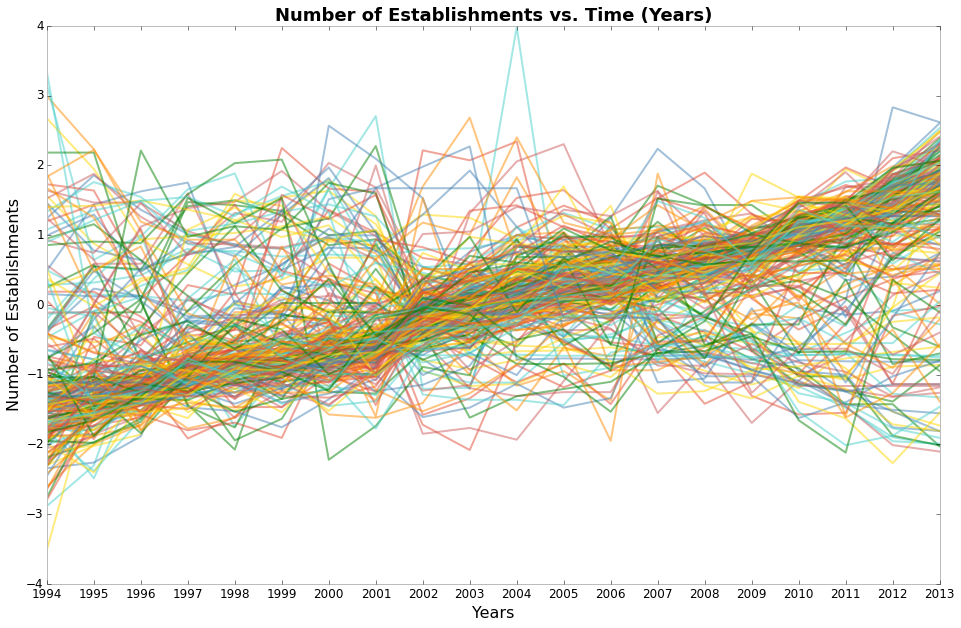

In [25]:
plt.figure(figsize=(16,10))

for i in range(len(df_zbgAll2)-1):
    plt.plot(range(20), df_zbgAll2.iloc[i], '-', alpha=0.5)
    
ax = plt.axes()
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.title('Number of Establishments vs. Time (Years)', fontsize=18, fontweight='bold')

plt.xlabel('Years', fontsize=16)
ax.set_xticks(range(0,21))
ax.set_xticklabels(['1994','1995','1996','1997','1998','1999','2000', '2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013'])
plt.xlim(0,19)
plt.ylabel('Number of Establishments', fontsize=16)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid()

In [46]:
s = []
for i in range(len(df_zbgAll2)-1):
    s.append(df_zbgAll2.iloc[i])

At 2 clusters, silhouette score is 0.5616
At 3 clusters, silhouette score is 0.5305
At 4 clusters, silhouette score is 0.4239
At 5 clusters, silhouette score is 0.3043
At 6 clusters, silhouette score is 0.2553
At 7 clusters, silhouette score is 0.2529
At 8 clusters, silhouette score is 0.1523
At 9 clusters, silhouette score is 0.1666
At 10 clusters, silhouette score is 0.1527


(0.0, 0.6)

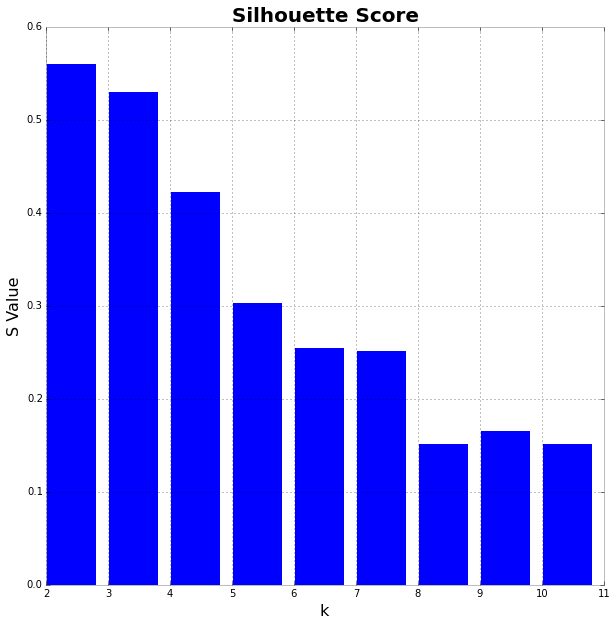

In [36]:
h = np.zeros(9)
for k in range(0, 9):
    est = KMeans(n_clusters = k+2, n_init = 100)
    est.fit(df_zbgAll2.values)
    h[k] = silhouette_score(df_zbgAll2, est.labels_)
    print('At {0} clusters, silhouette score is {1:.4f}'.format(k+2, h[k])) #successful float formatting!!!!
    
figure(figsize=(10, 10))
plt.bar(range(2, 11), h)
plt.xlabel('k', fontsize = 16)
plt.ylabel('S Value', fontsize = 16)
plt.title('Silhouette Score', fontsize = 20, fontweight='bold')
plt.ylim(0.0, .6)

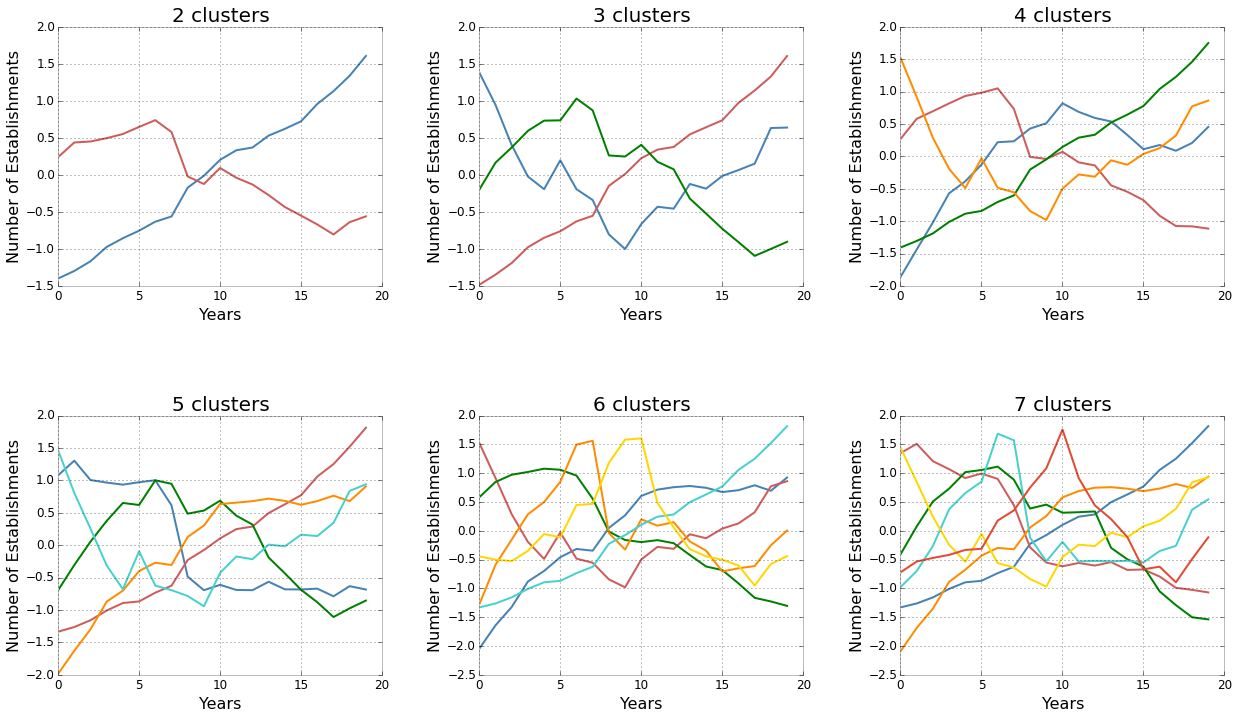

In [51]:
plt.figure(figsize=(18,18), dpi=200)
p = 1
for i in range(6):
    biz=k_means(s,n_clusters = i+2)
    #biz.fit(df_zbgAll2.values)
    plt.subplot(2, 3, p)
    p += 1
    plt.plot(range(20), transpose(biz[0]))
    plt.title(str(i+2)+' clusters', fontsize = 20)
    plt.ylabel('Number of Establishments', fontsize = 16)
    plt.xlabel('Years', fontsize = 16)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend()
plt.subplots_adjust(wspace=.3, hspace=0.5, left=0, right=0.9, top=0.5, bottom=0)

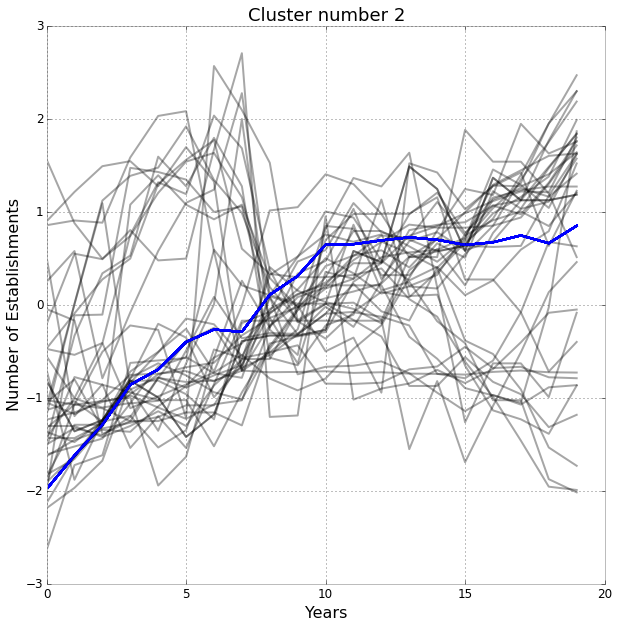

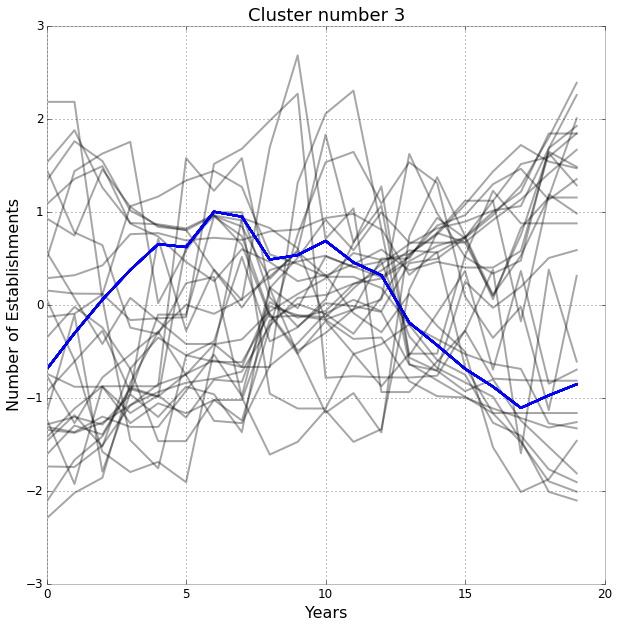

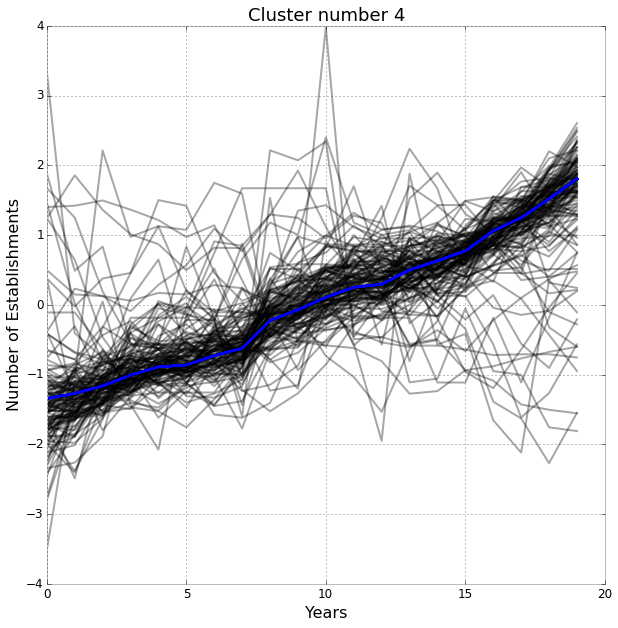

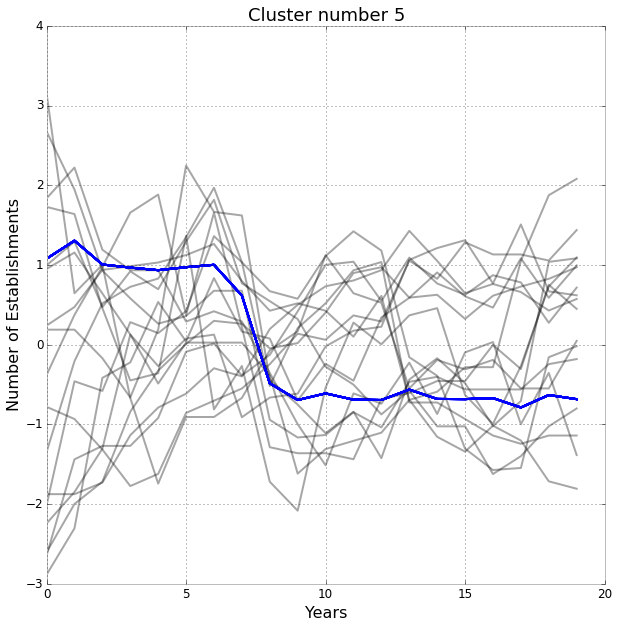

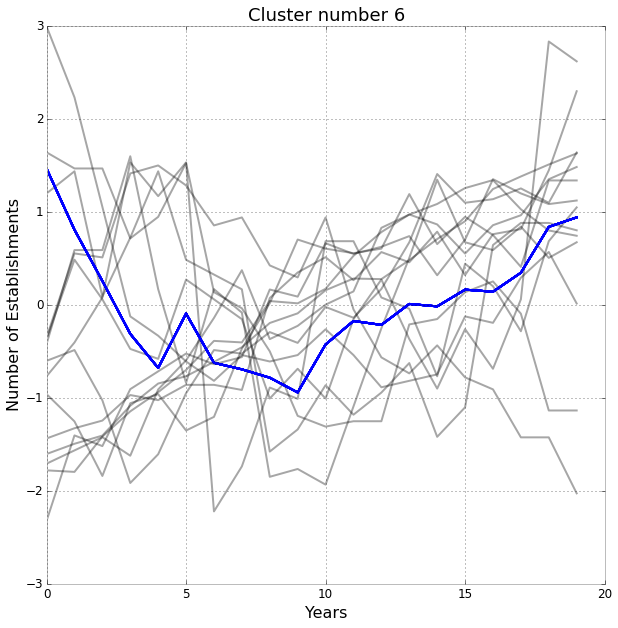

In [65]:
#biz_zip=pd.DataFrame(columns=['zips'],data=zips).drop_duplicates(inplace=True)
biz2 = k_means(df_zbgAll2.values,n_clusters=5)
biz_zip = pd.DataFrame({'zip': df_zbgAll2.index, 'cluster': biz2[1]})
#biz_zip['cluster'] = biz2[1]
for m in range(5):
    i = 0
    fig0 = plt.figure(figsize=(10,10));
    ax0 = fig0.add_subplot(1,1,1);
    for j in biz2[1]:
        if j==m:
            ax0.plot(range(20),s[i-1],c='k', alpha = 0.35)
            ax0.plot(range(20),biz2[0][j],c='b')
            plt.title('Cluster number ' + str(m+2), fontsize=18)
            plt.ylabel('Number of Establishments', fontsize = 16)
            plt.xlabel('Years', fontsize = 16)
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)
           
        i+=1      

### Geopandas does not run stable on my computer so I was unable to plot the maps